In [1]:
from typing import Callable

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import modred as mr
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.models import MLP
from src.solvers.fem import Poisson1D, HelmholtzImpedance1D, ParameterizedSolver, plot_bases
from src.utils.helpers import PairDataset, MSE, RelMSE

In [13]:
sns.set_theme(style='whitegrid', palette='deep')

# Generate data

In [3]:
N_h = 101

a = [
    (4. * np.pi),
    (.25 * np.pi),
    # lambda x: 30,
    # lambda x: x ** 2,
    # lambda x: 1j * 20 * (x ** 4),
    # lambda x: 10 * np.exp(x),
    # lambda x: 10 * np.exp(3 * (x ** 2)),
    # lambda x: 1j * 10 * np.exp(-5 * x),
    # lambda x: 15 * np.sin(x),
    # lambda x: -10 * np.cos(3 * x),
]
M = len(a)

if False:
    solver = HelmholtzImpedance1D(k=(4. * np.pi), ga=10., gb=20., f=None, a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='f')
elif True:
    solver = HelmholtzImpedance1D(k=None, ga=10., gb=20., f=(lambda x: x), a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')
elif True:
    # NOTE: Solutions are wrong, needs to be checked
    solver = Poisson1D(f=lambda x: np.sin(x), k=None, N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')

/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:370: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:371: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


In [4]:
n_trn = 300
n_val = 100
n = n_trn + n_val

Y = np.concatenate(
    [
        np.ones(shape=(1, n)),
        2 * np.random.random_sample(size=(M-1, n)) - 1,
    ],
    axis=0,
)
S = parsolver.solve(y=Y)

S_trn, S_val = S[:, :n_trn], S[:, n_trn:]
y_trn, y_val = Y[:, :n_trn], Y[:, n_trn:]


rank(S): 12


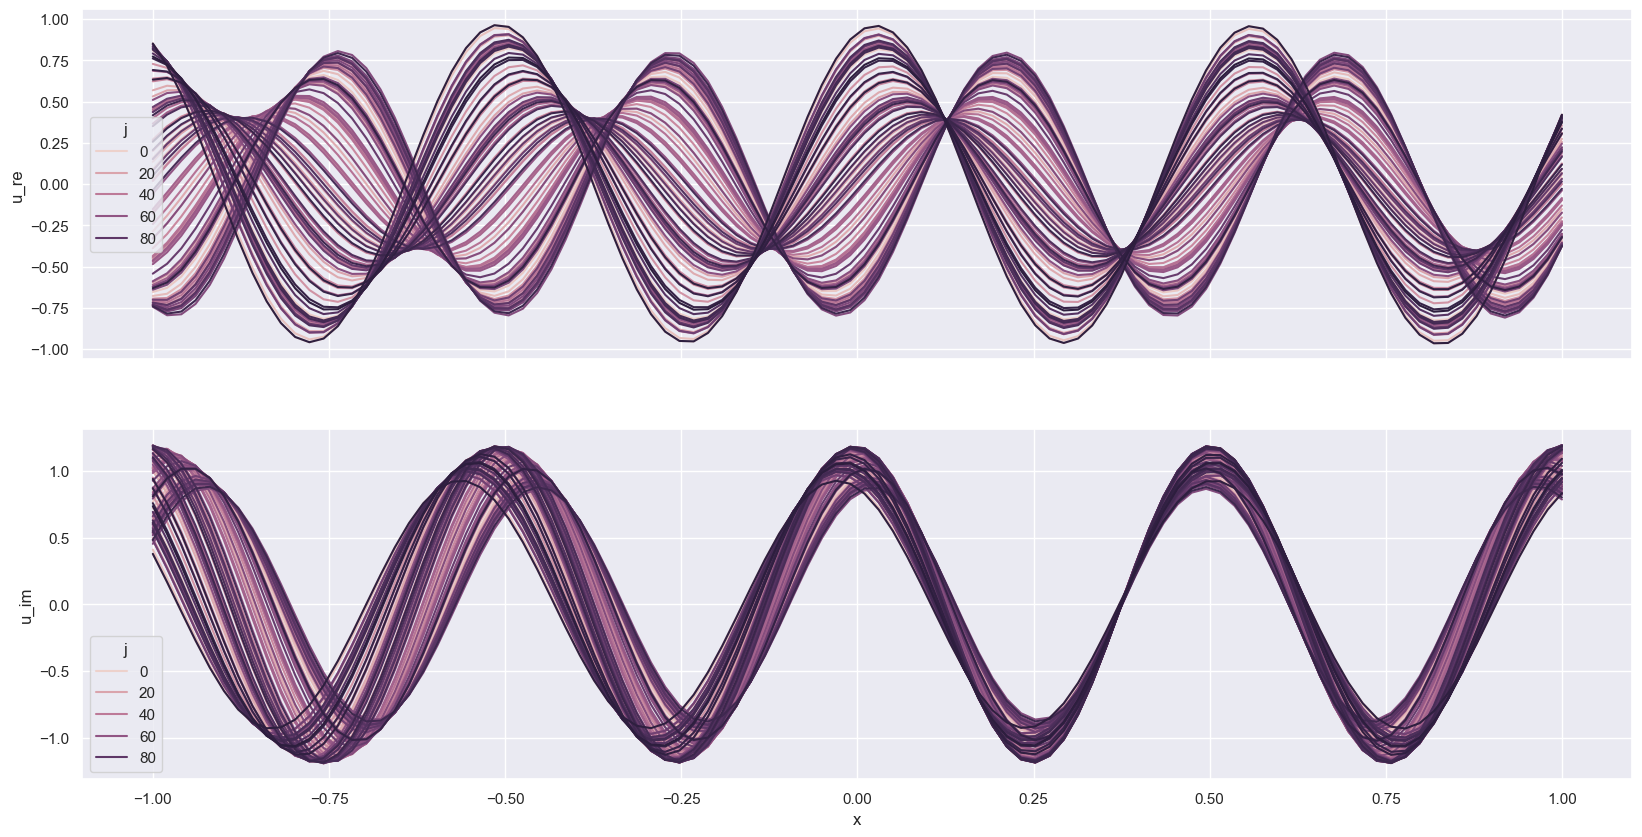

In [6]:
plot_bases(S=S, bases=solver.bases)
print(f'rank(S): {np.linalg.matrix_rank(S)}')

# Read and split data

In [3]:
Y = h5py.File('data/hfparams.h5', 'r')['Parameters'][:].T
S = h5py.File('data/hfsolutions.h5', 'r')['HfSolutions'][:].T
assert Y.shape[1] == S.shape[1]
M = Y.shape[0]
n = Y.shape[1]

In [4]:
ratio_val = .25

n_val = int(ratio_val * n)
n_trn = n - (n_val)
print(n_trn, n_val)

indices = np.random.permutation(n)
idx_trn, idx_val = indices[:n_trn], indices[n_trn:]
S_trn, S_val = S[:, idx_trn], S[:, idx_val]
y_trn, y_val = Y[:, idx_trn], Y[:, idx_val]

384 128


[Text(0.5, 0, '$i$'), Text(0, 0.5, '$s_i$'), None]

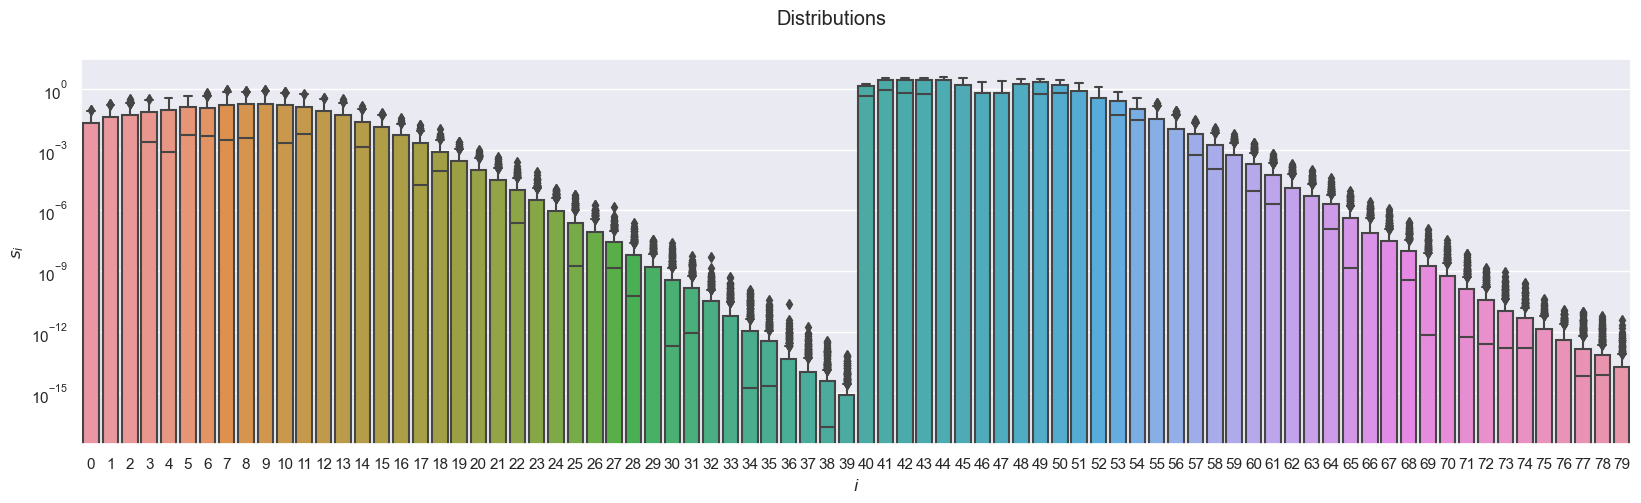

In [6]:
# Plot the distributions of the solution matrix
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20, 5))
fig.suptitle('Distributions')
if np.iscomplexobj(S):
    sns.boxplot(pd.DataFrame(np.concatenate([S.real, S.imag]).T), ax=ax)
else:
    sns.boxplot(pd.DataFrame(S.T), ax=ax)
ax.set(xlabel='$i$', ylabel='$s_i$', yscale='log')

# Train a POD-NN

## Normalize the data

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$'), None]

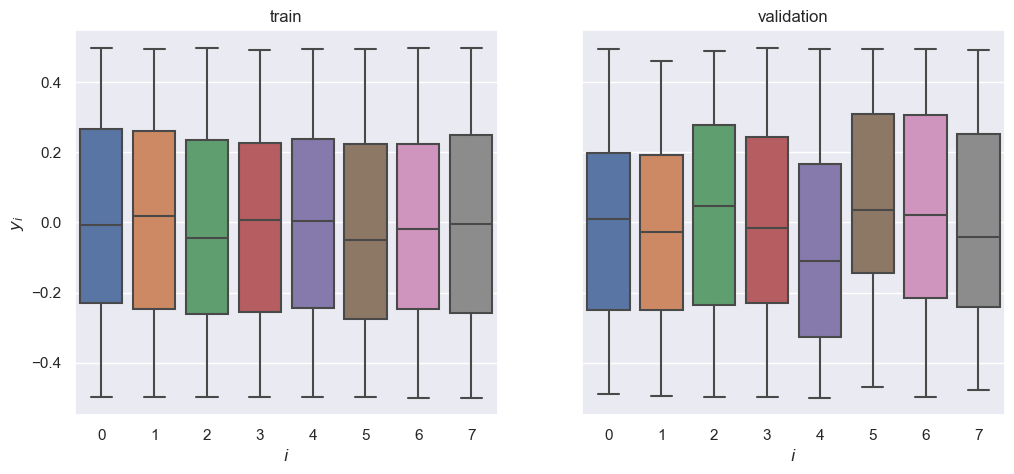

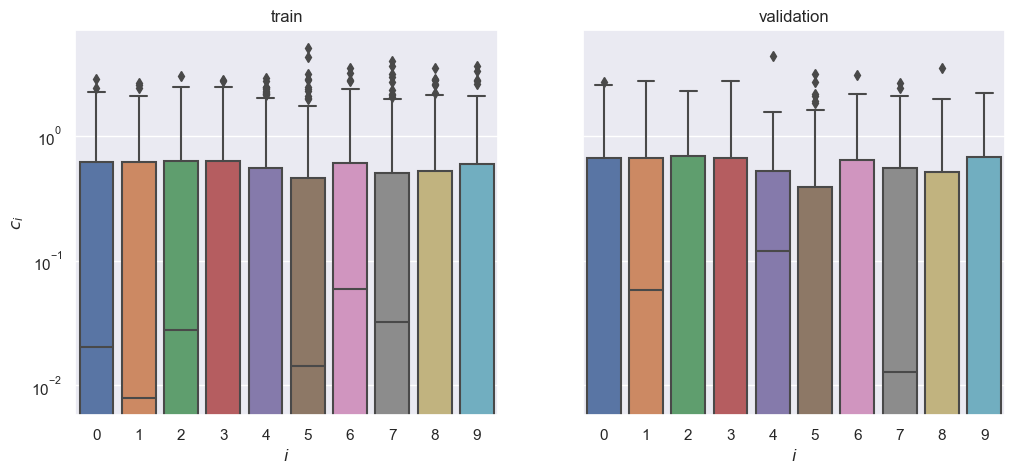

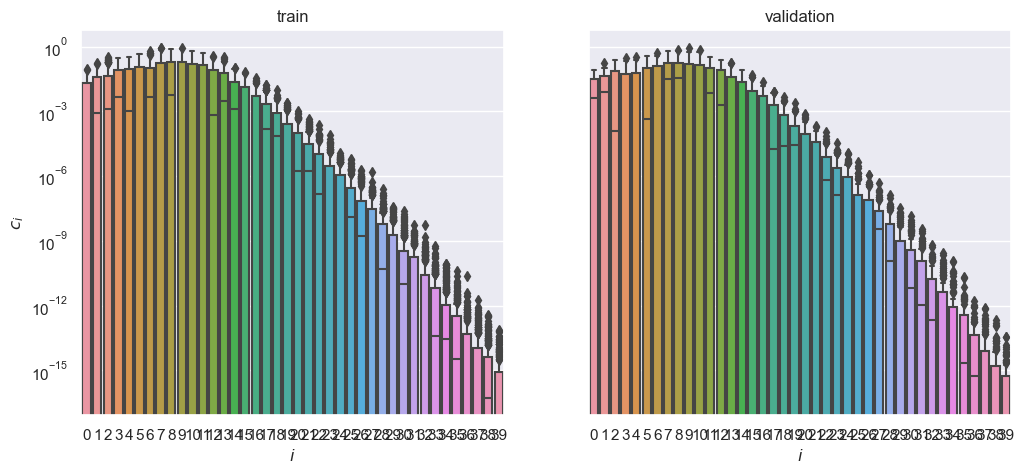

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
if np.iscomplexobj(Y):
    sns.boxplot(pd.DataFrame(np.concatenate([y_trn.real, y_trn.imag]).T), ax=axs[0])
    sns.boxplot(pd.DataFrame(np.concatenate([y_val.real, y_val.imag]).T), ax=axs[1])
else:
    sns.boxplot(pd.DataFrame(y_trn.T), ax=axs[0])
    sns.boxplot(pd.DataFrame(y_val.T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$y_i$')
axs[1].set(title='validation', xlabel='$i$')

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
if np.iscomplexobj(S):
    sns.boxplot(pd.DataFrame(np.concatenate([c_trn.real, c_trn.imag]).T), ax=axs[0])
    sns.boxplot(pd.DataFrame(np.concatenate([c_val.real, c_val.imag]).T), ax=axs[1])
else:
    sns.boxplot(pd.DataFrame(c_trn.T), ax=axs[0])
    sns.boxplot(pd.DataFrame(c_val.T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$', yscale='log')

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
if np.iscomplexobj(S):
    sns.boxplot(pd.DataFrame(np.concatenate([S_trn.real, S_trn.imag]).T), ax=axs[0])
    sns.boxplot(pd.DataFrame(np.concatenate([S_val.real, S_val.imag]).T), ax=axs[1])
else:
    sns.boxplot(pd.DataFrame(S_trn.T), ax=axs[0])
    sns.boxplot(pd.DataFrame(S_val.T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$S_i$')
axs[1].set(title='validation', xlabel='$i$', yscale='log')

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$')]

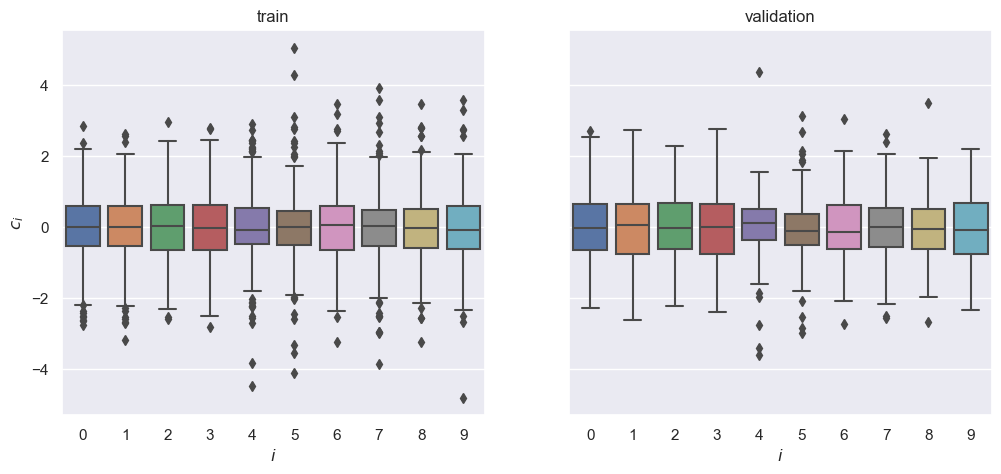

In [ ]:
mean_c_trn, std_c_trn = c_trn.mean(axis=1, keepdims=True), c_trn.std(axis=1, keepdims=True)
mean_c_val, std_c_val = c_val.mean(axis=1, keepdims=True), c_val.std(axis=1, keepdims=True)

c_trn = ((c_trn - mean_c_trn) / std_c_trn)
c_val = ((c_val - mean_c_val) / std_c_val)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
sns.boxplot(pd.DataFrame(c_trn.T), ax=axs[0])
sns.boxplot(pd.DataFrame(c_val.T), ax=axs[1])
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

## Get the reduced basis

In [5]:
print(S.shape[1], S_trn.shape[1], S_val.shape[1])
print(
    np.linalg.matrix_rank(S),
    np.linalg.matrix_rank(S_trn),
    np.linalg.matrix_rank(S_val),
)

512 384 128
73 74 74


[None, Text(0.5, 0, 'k'), Text(0, 0.5, '$\\lambda_k$')]

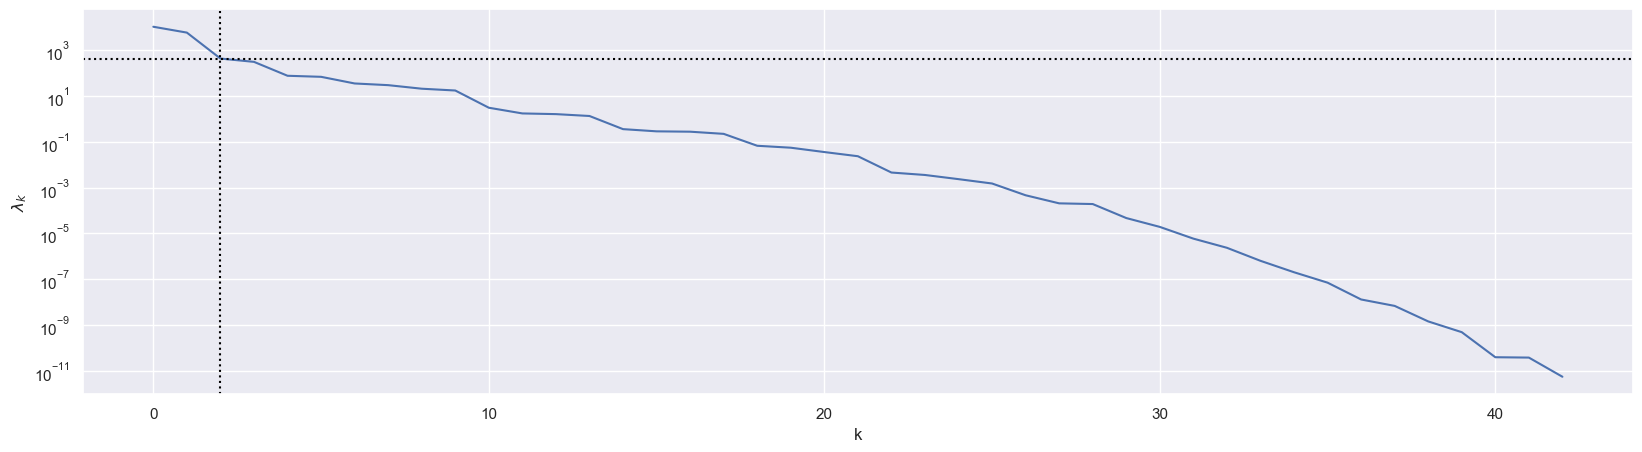

In [7]:
L = 2

# Check the dimension of the reduced basis
assert L <= np.linalg.matrix_rank(S_trn)

# Get the reduced basis and the coefficients
pod = mr.compute_POD_arrays_snaps_method(
    S_trn,
    list(mr.range(L))
)
V = pod.modes
c_trn = V.conj().T @ S_trn
c_val = V.conj().T @ S_val

# Plot the eigenvalues
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.lineplot(x=range(len(pod.eigvals)), y=pod.eigvals, ax=ax)
ax.axvline(x=L, color='black', linestyle=':')
ax.axhline(y=pod.eigvals[L], color='black', linestyle=':')
ax.set(yscale='log', xlabel='k', ylabel='$\\lambda_k$')

## Train the network

In [22]:
# Convergence study
Ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30]
repeat = 2
verbose = False

# Settings
D = 2
W = 40
epochs = 200 * 1e03
lr = 5e-03
wd = 0
bsz = None
batch_norm = False
activation = torch.tanh
scheduler = False

# Assertion for batch norm
if batch_norm and bsz:
    assert bsz > 1

# Train for each L
eigvals = [None] * len(Ls)
losses = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
errors = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
for idx, L in enumerate(Ls):
    # Print
    print('-' * 50)
    print(f'L = {L}')

    # Get the reduced basis and the coefficients
    pod = mr.compute_POD_arrays_snaps_method(
        S_trn,
        list(mr.range(L))
    )
    V = pod.modes
    eigvals[idx] = pod.eigvals[L-1]
    c_trn = V.conj().T @ S_trn
    c_val = V.conj().T @ S_val

    # Define data loaders
    trainloader = DataLoader(
        dataset=PairDataset(y=y_trn, c=S_trn),
        batch_size=(bsz if bsz else y_trn.shape[1]),
        shuffle=True,
        drop_last=batch_norm,
    )
    validationloader = DataLoader(
        dataset=PairDataset(y=y_val, c=S_val),
        batch_size=(bsz if bsz else y_val.shape[1]),
        shuffle=False,
    )

    for _ in range(repeat):
        # Define model, criterion, and optimizer
        model = MLP(
            M=M,
            L=L,
            V=V,
            hidden_layers=([W] * D),
            activation=activation,
            gain=1.,
            dtype=torch.float64,
        )
        # criterion = torch.nn.MSELoss()
        criterion = MSE
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.9, weight_decay=wd)
        if scheduler:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-04, T_max=epochs)
        else:
            scheduler = None

        # Train the model
        print(f'{model.__class__.__name__} with {model.numparams()} parameters')
        stats, paramsdict = model.train_(
            criterion=criterion,
            epochs=int(epochs),
            optimizer=optimizer,
            trainloader=trainloader,
            validationloader=validationloader,
            scheduler=scheduler,
            cuda=False,
            store_params=False,
        )
        # Clean the stats
        params = paramsdict['params']
        grads = paramsdict['grads']
        # Get the outputs and compute the errors
        model.eval()
        S_trn_, c_trn_ = model(torch.tensor(y_trn.T))
        S_val_, c_val_ = model(torch.tensor(y_val.T))
        S_trn_, c_trn_ = S_trn_.detach().numpy().T, c_trn_.detach().numpy().T
        S_val_, c_val_ = S_val_.detach().numpy().T, c_val_.detach().numpy().T
        err_trn = RelMSE(torch.tensor(S_trn_).T, torch.tensor(S_trn).T).item()
        err_val = RelMSE(torch.tensor(S_val_).T, torch.tensor(S_val).T).item()

        # Plot the training procedure
        if verbose:
            # Print the final losses
            print('\t\t'.join([
                'LOSS ::',
                f"Train: {stats['loss_trn'][-1]:.2e}",
                f"Validation: {stats['loss_val'][-1]:.2e}",
            ]))
            # Print the final errors
            print('\t\t'.join([
                'ERRS ::',
                f"Train: {err_trn:.2e}",
                f"Validation: {err_val:.2e}",
            ]))

            # Plot the stats
            df = pd.DataFrame(stats)
            fig, axs = plt.subplots(1, 2, figsize=(20, 5))
            sns.lineplot(df, x='epoch', y='loss_trn', ax=axs[0], label='Training')
            sns.lineplot(df, x='epoch', y='loss_val', ax=axs[0], label='Validation')
            axs[0].set(yscale='log', ylim=[1e-08, 1e04])
            axs[0].legend()
            sns.lineplot(df, x='epoch', y='lr', ax=axs[1])
            axs[1].set(yscale='log')

        # Skip if the validation loss is not smaller than before
        if losses['validation'][idx] and losses['validation'][idx] < stats['loss_val'][-1]:
            continue

        # Store the losses
        losses['train'][idx] = stats['loss_trn'][-1]
        losses['validation'][idx] = stats['loss_val'][-1]
        # Store the errors
        errors['train'][idx] = err_trn
        errors['validation'][idx] = err_val

    # Print the final losses
    print('\t\t'.join([
        'LOSS ::',
        f"Train: {losses['train'][idx]:.2e}",
        f"Validation: {losses['validation'][idx]:.2e}",
    ]))
    # Print the final errors
    print('\t\t'.join([
        'ERRS ::',
        f"Train: {err_trn:.2e}",
        f"Validation: {err_val:.2e}",
    ]))


--------------------------------------------------
L = 1
MLP with 2203 parameters


100%|██████████| 200000/200000 [06:07<00:00, 543.65it/s]


MLP with 2203 parameters


100%|██████████| 200000/200000 [06:11<00:00, 538.28it/s]


LOSS ::		Train: 1.75e+01		Validation: 1.85e+01
ERRS ::		Train: 4.60e-01		Validation: 4.72e-01
--------------------------------------------------
L = 2
MLP with 2246 parameters


100%|██████████| 200000/200000 [06:06<00:00, 545.74it/s]


MLP with 2246 parameters


100%|██████████| 200000/200000 [05:59<00:00, 556.99it/s]


LOSS ::		Train: 2.41e+00		Validation: 2.80e+00
ERRS ::		Train: 5.73e-02		Validation: 6.51e-02
--------------------------------------------------
L = 3
MLP with 2289 parameters


100%|██████████| 200000/200000 [06:13<00:00, 535.14it/s]


MLP with 2289 parameters


100%|██████████| 200000/200000 [06:04<00:00, 548.64it/s]


LOSS ::		Train: 1.40e+00		Validation: 1.67e+00
ERRS ::		Train: 3.14e-02		Validation: 4.31e-02
--------------------------------------------------
L = 4
MLP with 2332 parameters


100%|██████████| 200000/200000 [05:59<00:00, 556.74it/s]


MLP with 2332 parameters


100%|██████████| 200000/200000 [05:58<00:00, 557.25it/s]


LOSS ::		Train: 6.43e-01		Validation: 6.95e-01
ERRS ::		Train: 1.52e-02		Validation: 2.39e-02
--------------------------------------------------
L = 5
MLP with 2375 parameters


100%|██████████| 200000/200000 [06:02<00:00, 551.10it/s]


MLP with 2375 parameters


100%|██████████| 200000/200000 [06:00<00:00, 555.02it/s]


LOSS ::		Train: 4.66e-01		Validation: 6.90e+00
ERRS ::		Train: 1.15e-02		Validation: 1.56e-01
--------------------------------------------------
L = 6
MLP with 2418 parameters


100%|██████████| 200000/200000 [06:13<00:00, 535.76it/s]


MLP with 2418 parameters


100%|██████████| 200000/200000 [06:06<00:00, 545.71it/s]


LOSS ::		Train: 2.90e-01		Validation: 3.17e-01
ERRS ::		Train: 6.95e-03		Validation: 7.25e-03
--------------------------------------------------
L = 7
MLP with 2461 parameters


100%|██████████| 200000/200000 [06:00<00:00, 554.37it/s]


MLP with 2461 parameters


100%|██████████| 200000/200000 [06:00<00:00, 555.39it/s]


LOSS ::		Train: 1.96e-01		Validation: 2.45e-01
ERRS ::		Train: 4.58e-03		Validation: 5.52e-03
--------------------------------------------------
L = 8
MLP with 2504 parameters


100%|██████████| 200000/200000 [05:58<00:00, 558.57it/s]


MLP with 2504 parameters


100%|██████████| 200000/200000 [05:58<00:00, 558.15it/s]


LOSS ::		Train: 1.22e-01		Validation: 1.32e-01
ERRS ::		Train: 2.89e-03		Validation: 3.06e-03
--------------------------------------------------
L = 9
MLP with 2547 parameters


100%|██████████| 200000/200000 [06:03<00:00, 549.84it/s]


MLP with 2547 parameters


100%|██████████| 200000/200000 [06:02<00:00, 551.82it/s]


LOSS ::		Train: 7.14e-02		Validation: 8.25e-02
ERRS ::		Train: 1.67e-03		Validation: 1.84e-03
--------------------------------------------------
L = 10
MLP with 2590 parameters


100%|██████████| 200000/200000 [06:04<00:00, 548.25it/s]


MLP with 2590 parameters


100%|██████████| 200000/200000 [06:00<00:00, 554.44it/s]


LOSS ::		Train: 2.77e-02		Validation: 5.07e-02
ERRS ::		Train: 6.72e-04		Validation: 1.25e-03
--------------------------------------------------
L = 11
MLP with 2633 parameters


100%|██████████| 200000/200000 [06:01<00:00, 553.74it/s]


MLP with 2633 parameters


100%|██████████| 200000/200000 [05:59<00:00, 556.36it/s]


LOSS ::		Train: 2.23e-02		Validation: 4.48e-02
ERRS ::		Train: 5.30e-04		Validation: 9.97e-04
--------------------------------------------------
L = 12
MLP with 2676 parameters


100%|██████████| 200000/200000 [06:04<00:00, 549.25it/s]


MLP with 2676 parameters


100%|██████████| 200000/200000 [06:02<00:00, 551.17it/s]


LOSS ::		Train: 1.91e-02		Validation: 4.08e-02
ERRS ::		Train: 4.48e-04		Validation: 9.05e-04
--------------------------------------------------
L = 15
MLP with 2805 parameters


100%|██████████| 200000/200000 [06:11<00:00, 538.45it/s]


MLP with 2805 parameters


100%|██████████| 200000/200000 [06:06<00:00, 546.06it/s]


LOSS ::		Train: 1.72e-02		Validation: 4.58e-02
ERRS ::		Train: 4.04e-04		Validation: 1.02e-03
--------------------------------------------------
L = 20
MLP with 3020 parameters


100%|██████████| 200000/200000 [06:13<00:00, 534.94it/s]


MLP with 3020 parameters


100%|██████████| 200000/200000 [06:11<00:00, 538.24it/s]


LOSS ::		Train: 1.64e-02		Validation: 4.16e-02
ERRS ::		Train: 3.86e-04		Validation: 9.09e-04
--------------------------------------------------
L = 30
MLP with 3450 parameters


  3%|▎         | 5860/200000 [00:11<06:21, 508.45it/s]


KeyboardInterrupt: 

## Plot weights, biases, and outputs

In [17]:
# Read the parameters and the gradients
params_ = {}
grads_ = {}
for name, vals in params.items():
    if not model.bn and 'bn' in name:
        continue
    params_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])):
        val = vals[e].flatten()
        params_[name]['epoch'].extend([e] * len(val))
        params_[name]['val'].extend(val)
for name, vals in grads.items():
    if not model.bn and 'bn' in name:
        continue
    grads_[name] = {'epoch': [], 'val': []}
    for e in range(len(stats['epoch'])-1):
        if vals[e] is None:
            continue
        val = vals[e].flatten()
        grads_[name]['epoch'].extend([e] * len(val))
        grads_[name]['val'].extend(val)
params = {name: pd.DataFrame(params_[name]) for name in params_.keys()}
grads = {name: pd.DataFrame(grads_[name]) for name in grads_.keys()}

# Plot the parameters
ncols = 2
nrows = (len(params) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(20, 5 * nrows)
)
axs = axs.flatten()

for idx, (name, df) in enumerate(params.items()):
    sns.boxplot(
        data=df[
            (df['epoch'] % (epochs // 10) == 0)
            # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
        ],
        x='epoch', y='val',
        color='blue',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)

# Plot the gradients
ncols = 2
nrows = (len(grads) + 1) // ncols
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(20, 5 * nrows)
)
axs = axs.flatten()
for idx, (name, df) in enumerate(grads.items()):
    sns.boxplot(
        data=df[
            (df['epoch'] % (epochs // 10) == 0)
            # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
        ],
        x='epoch', y='val',
        color='green',
        showfliers=False,
        ax=axs[idx],
    )

    axs[idx].set(ylabel='', xlabel='', title=name)

# Plot the outputs
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
sns.boxplot(pd.DataFrame(c_trn_.T), ax=axs[0])
sns.boxplot(pd.DataFrame(c_val_.T), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

KeyboardInterrupt: 

## Plot evaluations

[Text(0.5, 1.0, 'validation'), Text(0.5, 0, '$i$'), None]

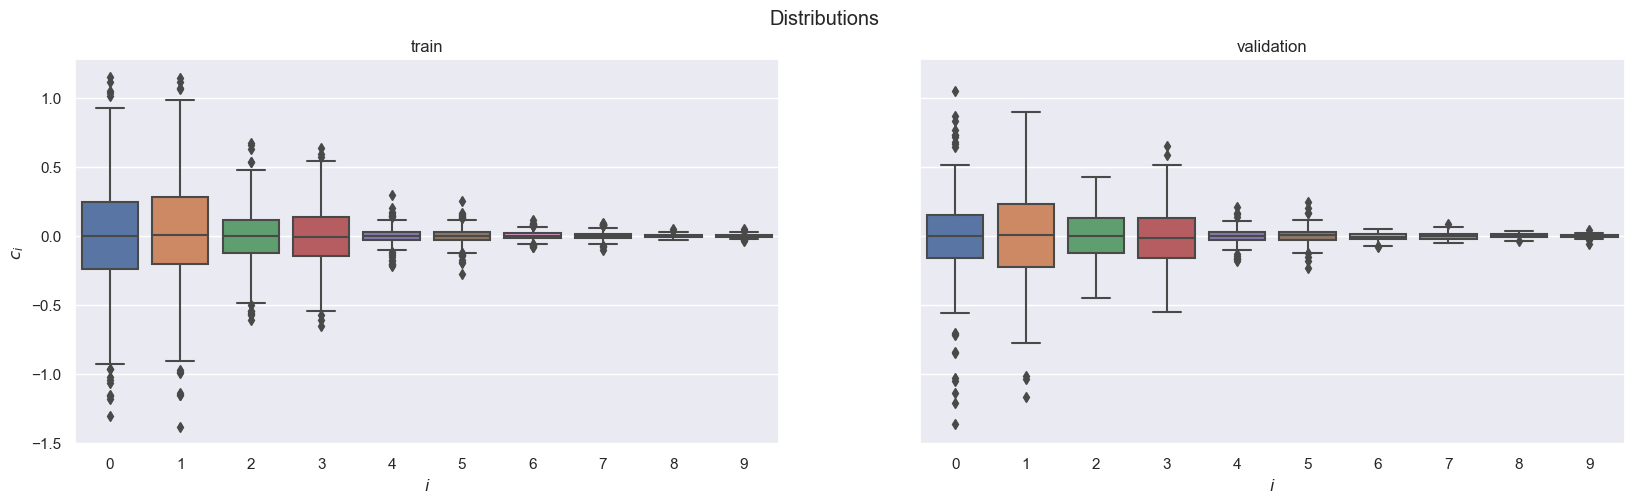

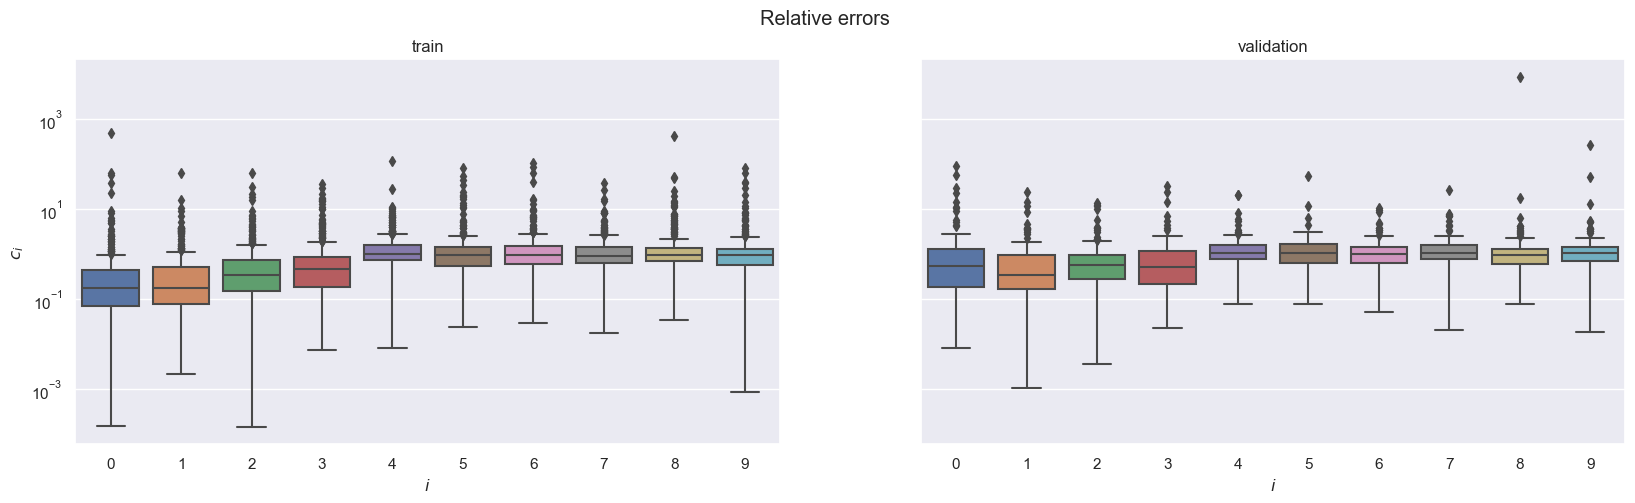

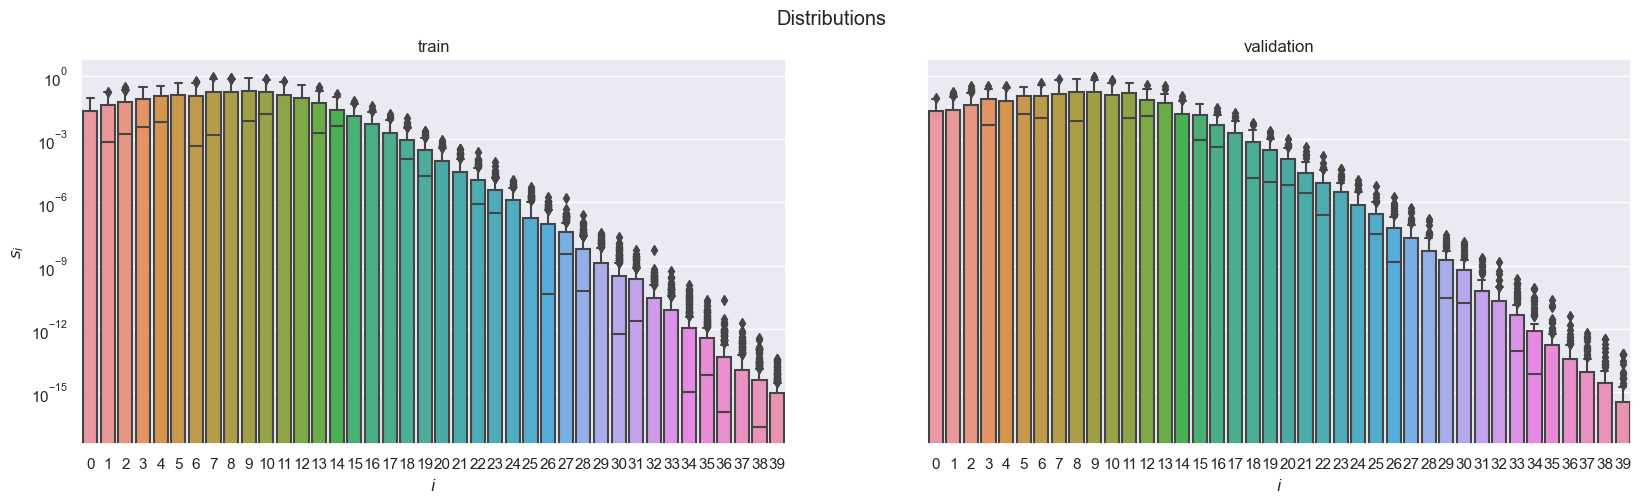

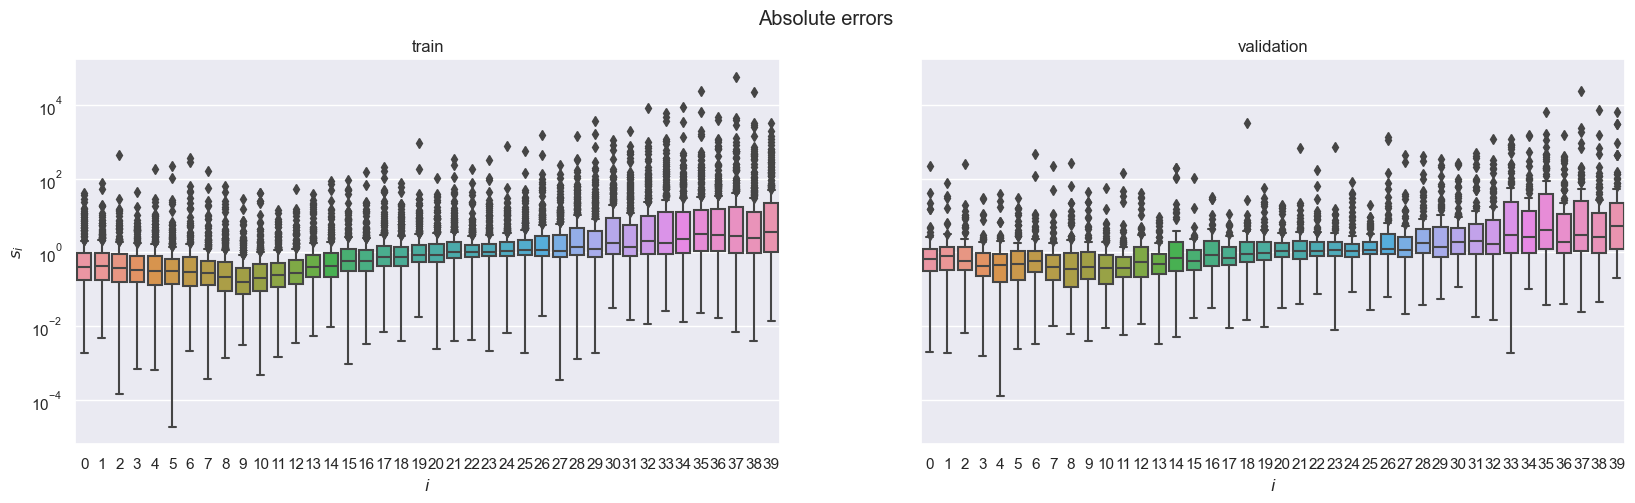

In [60]:
# Plot the distributions of the coefficients
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
if np.iscomplexobj(S):
    sns.boxplot(pd.DataFrame(np.concatenate([c_trn.real, c_trn.imag]).T), ax=axs[0])
    sns.boxplot(pd.DataFrame(np.concatenate([c_val.real, c_val.imag]).T), ax=axs[1])
else:
    sns.boxplot(pd.DataFrame(c_trn.T), ax=axs[0])
    sns.boxplot(pd.DataFrame(c_val.T), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$')

# Plot the error distributions of the coefficients
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
sns.boxplot(pd.DataFrame(np.abs((c_trn - c_trn_) / c_trn).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.abs((c_val - c_val_) / c_val).T), ax=axs[1])
fig.suptitle('Relative errors')
axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
axs[1].set(title='validation', xlabel='$i$', yscale='log')

# Plot the distributions of the solution matrices
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
if np.iscomplexobj(S):
    sns.boxplot(pd.DataFrame(np.concatenate([S_trn.real, S_trn.imag]).T), ax=axs[0])
    sns.boxplot(pd.DataFrame(np.concatenate([S_val.real, S_val.imag]).T), ax=axs[1])
else:
    sns.boxplot(pd.DataFrame(S_trn.T), ax=axs[0])
    sns.boxplot(pd.DataFrame(S_val.T), ax=axs[1])
fig.suptitle('Distributions')
axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
axs[1].set(title='validation', xlabel='$i$', yscale='log')

# Plot the error distributions of the solution matrices
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
sns.boxplot(pd.DataFrame(np.abs((S_trn - S_trn_) / S_trn).T), ax=axs[0])
sns.boxplot(pd.DataFrame(np.abs((S_val - S_val_) / S_val).T), ax=axs[1])
fig.suptitle('Absolute errors')
axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
axs[1].set(title='validation', xlabel='$i$', yscale='log')

In [ ]:
# # Plot the NN validation approximations
# plot_bases(S=S_val_, bases=solver.bases)
# # Plot the NN validation errors
# plot_bases(S=E_val, bases=solver.bases)

## Plot convergence

[Text(0, 0.5, '$\\lambda_L$'), None]

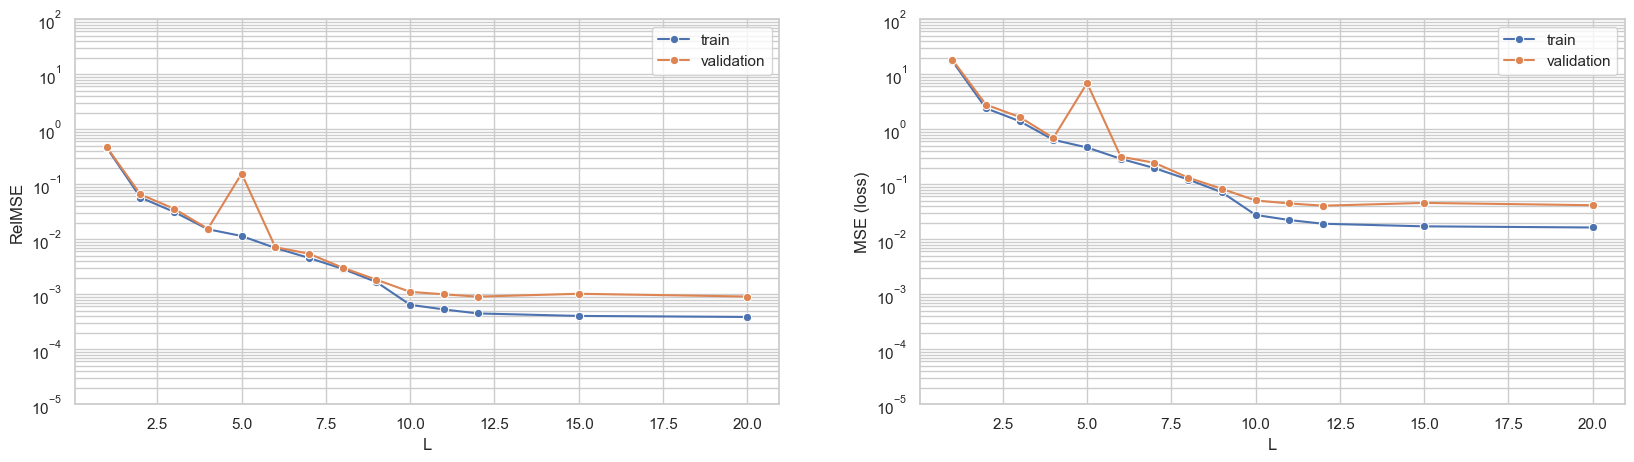

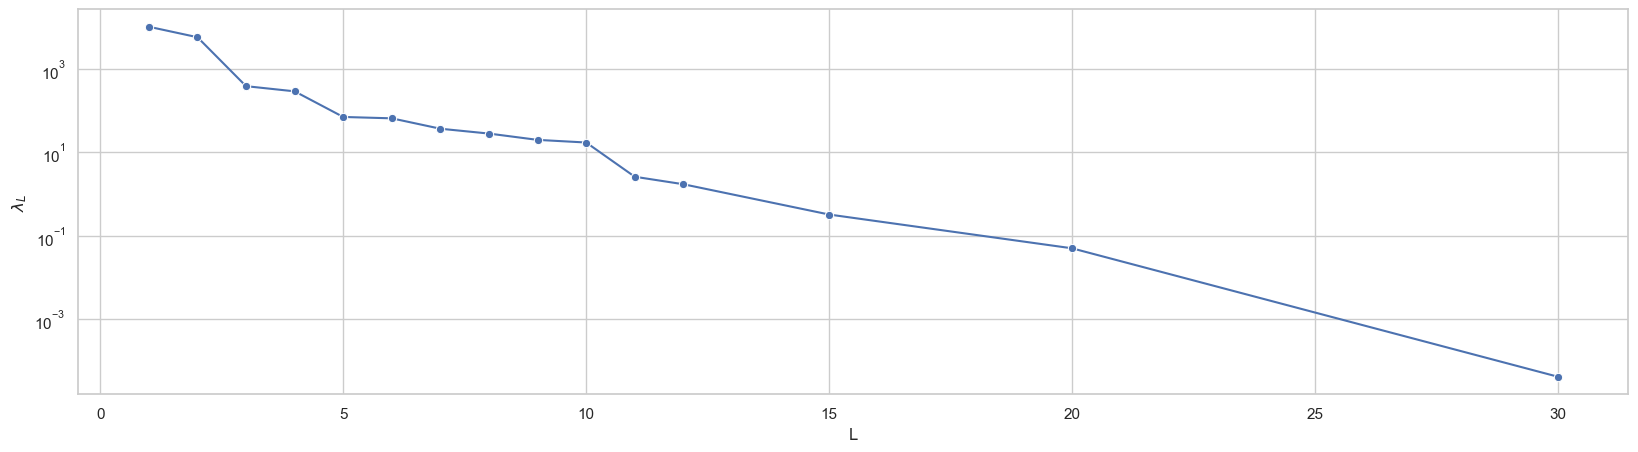

In [23]:
df = pd.DataFrame({
    'L': Ls,
    'eigval': eigvals,
    'train error': errors['train'],
    'validation error': errors['validation'],
    'train loss': losses['train'],
    'validation loss': losses['validation'],
})

# Plot the errors
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20, 5))
sns.lineplot(df, x='L', y='train error', marker='o', label='train', ax=axs[0])
sns.lineplot(df, x='L', y='validation error', marker='o', label='validation', ax=axs[0])
sns.lineplot(df, x='L', y='train loss', marker='o', label='train', ax=axs[1])
sns.lineplot(df, x='L', y='validation loss', marker='o', label='validation', ax=axs[1])
axs[0].set(ylabel='RelMSE', ylim=[1e-05, 1e+02])
axs[1].set(ylabel='MSE (loss)', ylim=[1e-05, 1e+02])
for ax in axs:
    ax.grid(True, which='minor')
    ax.set(yscale='log')
    ax.legend()

# Plot the singular values
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20, 5))
sns.lineplot(df, x='L', y='eigval', marker='o', ax=ax)
ax.set(ylabel='$\\lambda_L$', yscale='log')

In [24]:
df.to_csv(f'results/OneArc/D{D}W{W}_convg.csv')